# Next day rain prediction
An approach to camparing data preparation for next day rain predictions. Final project for Data Science bootcamp organized by Sages.

## Table of contents

1. Abstract

2. About dataset

3. Prerequisites and data load

4. Data understanding

5. Dealing with missing data

6. Final data preparation

7. Model training

8. Scores evaluation

9. Summary

## 1. Abstract

The goal of the project is to compare models metrics for different data preparation of next day rain predictions. On model prediction influence has not only the choosing of the best algorithm and its parameters, but big influence has data preparation and dealing with missing values. The project shows differend ways solving the problem.


## 2. About dataset
Dataset is about Rain in Australia from [Kaggle](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) platform.
Dataset contains from 2007 to 2017 of daily weather observation (145k) for locations across Australia. Due different weather stations collected data, in dataset is many location with 100% missing data for few variables.
Target variable is "RainTomorrow" it means - did it rain the next day.


## 3. Prerequisites and data load

Import of the necessery modules

In [298]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import inspect
import time
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from imblearn.pipeline import Pipeline as imbPipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


Data load

In [2]:
data_raw = pd.read_csv('weatherAUS.csv')

In [3]:
pd.options.mode.chained_assignment = None

## 4. Data understanding 

In [4]:
def first_look_at_data(df):
    print('Data information')
    print(df.info(),'\n\n')
    print('Number of unique values')
    print(df.nunique(), '\n\n')
    print('RainTomorrow values')
    print(df.RainTomorrow.value_counts(dropna=False),'\n\n')
    return df.describe().T

In [5]:
first_look_at_data(data_raw)

Data information
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am    

,count,mean,std,min,25%,50%,75%,max
MinTemp,143975.0,12.194034,6.398495,-8.5,7.6,12.0,16.9,33.9
MaxTemp,144199.0,23.221348,7.119049,-4.8,17.9,22.6,28.2,48.1
Rainfall,142199.0,2.360918,8.478060,0.0,0.0,0.0,0.8,371.0
Evaporation,82670.0,5.468232,4.193704,0.0,2.6,4.8,7.4,145.0
Sunshine,75625.0,7.611178,3.785483,0.0,4.8,8.4,10.6,14.5
WindGustSpeed,135197.0,40.035230,13.607062,6.0,31.0,39.0,48.0,135.0
WindSpeed9am,143693.0,14.043426,8.915375,0.0,7.0,13.0,19.0,130.0
WindSpeed3pm,142398.0,18.662657,8.809800,0.0,13.0,19.0,24.0,87.0
Humidity9am,142806.0,68.880831,19.029164,0.0,57.0,70.0,83.0,100.0
Humidity3pm,140953.0,51.539116,20.795902,0.0,37.0,52.0,66.0,100.0


First data preparation:
- change Date to datetime type, 
- take day of year, 
- converting 'Yes' and 'No' to 1 and 0 for RainToday, RainTomorrow variables

In [6]:
def first_and_basic_preparation(df, day_of_year=True, month_of_year=False):
    df.Date = pd.to_datetime(df.Date,format='%Y-%m-%d')
    if day_of_year == True:
        df['DayOfYear'] = df.Date.dt.day_of_year
    if month_of_year == True:
        df['Month'] = df.Date.dt.month
    df.RainToday = df.RainToday.map({'Yes':1,'No':0})
    df.RainTomorrow = df.RainTomorrow.map({'Yes':1,'No':0})
    return df

In [7]:
data = first_and_basic_preparation(data_raw)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   Date           145460 non-null  datetime64[ns]
 1   Location       145460 non-null  object        
 2   MinTemp        143975 non-null  float64       
 3   MaxTemp        144199 non-null  float64       
 4   Rainfall       142199 non-null  float64       
 5   Evaporation    82670 non-null   float64       
 6   Sunshine       75625 non-null   float64       
 7   WindGustDir    135134 non-null  object        
 8   WindGustSpeed  135197 non-null  float64       
 9   WindDir9am     134894 non-null  object        
 10  WindDir3pm     141232 non-null  object        
 11  WindSpeed9am   143693 non-null  float64       
 12  WindSpeed3pm   142398 non-null  float64       
 13  Humidity9am    142806 non-null  float64       
 14  Humidity3pm    140953 non-null  float64       
 15  

Object variables vizualization

In [9]:
def object_data_vizualization(df, date_location=True, wind=True, rain=True):
    if date_location == True:
        plt.figure(figsize=(15,4))
        plt.scatter(df.Location,df.Date, marker='.',c='k')
        plt.xticks(rotation=90)
        plt.title('Date for Locations',fontsize=15)
        plt.show()

    if wind == True:
        fig, axs = plt.subplots(1, 3, figsize=(15,8))
        df.WindGustDir.value_counts().plot.pie(autopct = '%1.1f%%', ax=axs[0])
        df.WindDir9am.value_counts().plot.pie(autopct = '%1.1f%%', ax=axs[1])
        df.WindDir3pm.value_counts().plot.pie(autopct = '%1.1f%%', ax=axs[2])
        plt.show()

    if rain == True:
        fig, axs = plt.subplots(1, 2, figsize=(15,3))
        df.RainToday.value_counts(normalize=True).plot(kind='bar', color=['g','b'], rot=0, ax=axs[0])
        axs[0].set_title('RainToday 0(No) and 1(Yes)')
        df.RainTomorrow.value_counts(normalize=True).plot(kind='bar', color=['g','b'], rot=0, ax=axs[1])
        axs[1].set_title('RainTomorrow 0(No) and 1(Yes)')
        plt.show()


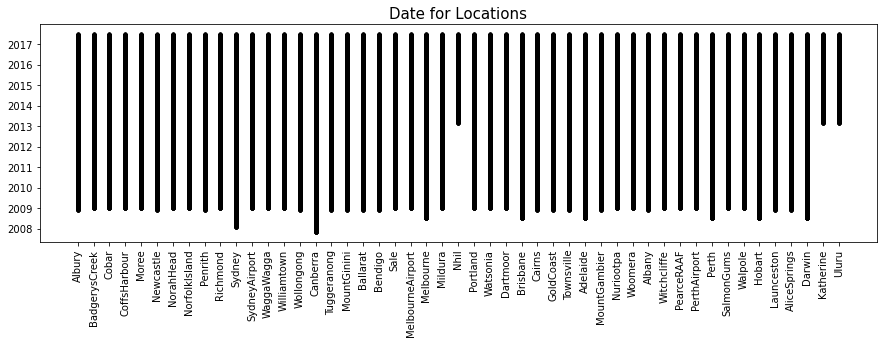

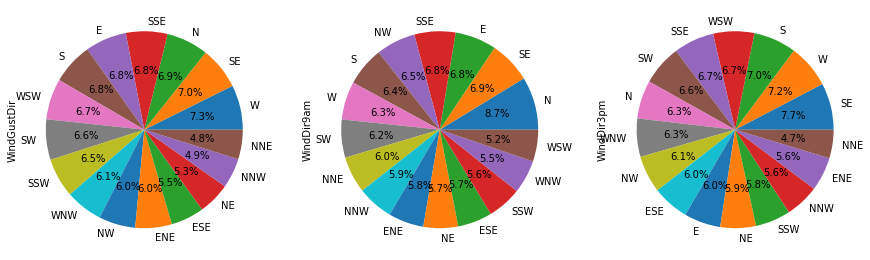

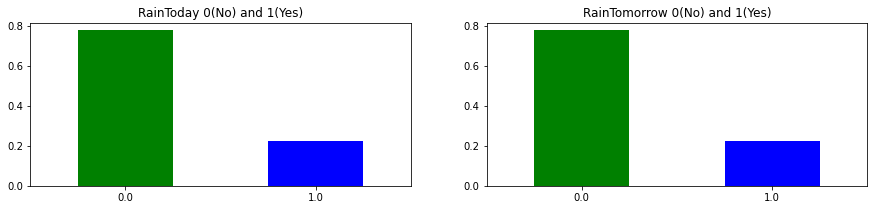

In [10]:
object_data_vizualization(data)

Numeric variables vizualization

In [11]:
def numeric_data_vizualization(df, histograms=True, boxplots=True, correlation=True):
    columns_hist = []
    columns_boxplot = []
    
    for i in df.columns:

        if df[i].dtypes == 'float64':
            columns_hist.append(i)
            if (df[i].max()/3) > df[i].quantile(q=0.75):
                    columns_boxplot.append(i)
    if histograms == True:
        df[columns_hist[:-2]].hist(figsize=(20,10),bins=50)
        plt.suptitle('Histograms',fontsize=15)
        plt.show()
    if boxplots == True:
        df[columns_boxplot[:-2]].boxplot(figsize=(15,3))
        plt.title('Boxplots for variables with outlires',fontsize=15)
        plt.show()
    if correlation == True:
        fig, axs = plt.subplots(figsize=(15,8))
        plt.title('Correlation matrix',fontsize=15)
        sns.heatmap(data.corr(), annot=True, fmt='.1%', cmap="coolwarm", cbar=False)

Distribution of numeric variables

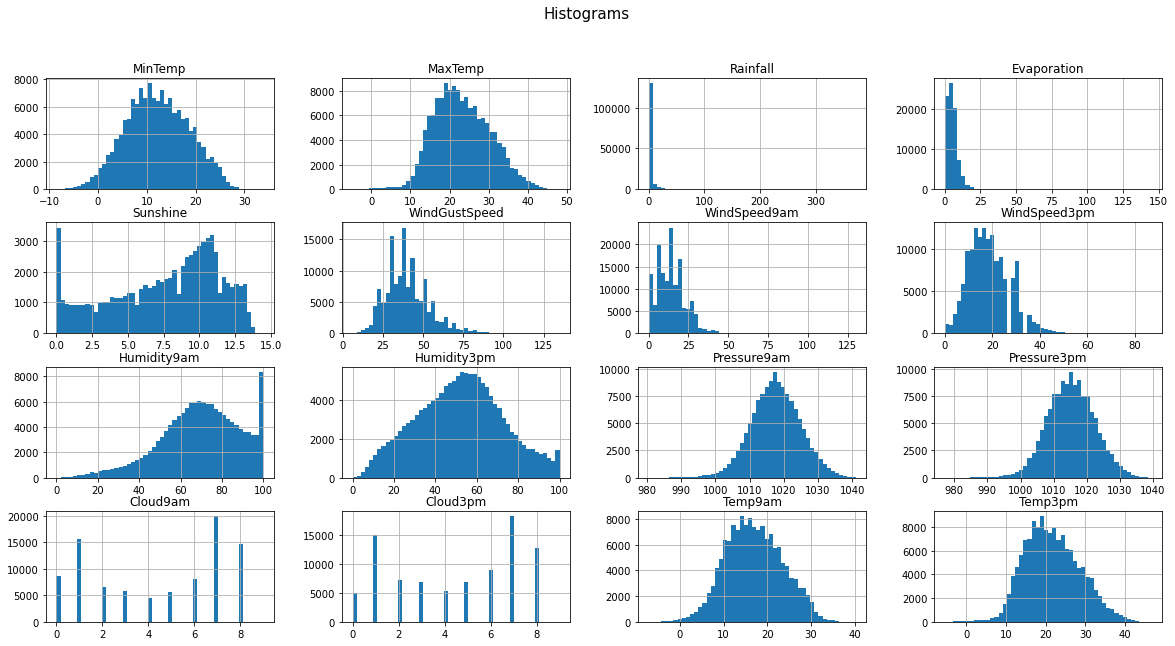

In [12]:
numeric_data_vizualization(data, histograms=True, boxplots=False, correlation=False)

Boxplots for variables with outliers

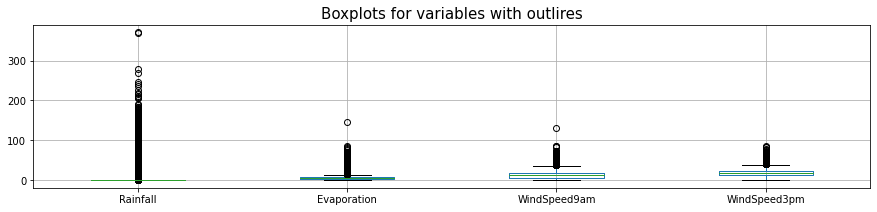

In [13]:
numeric_data_vizualization(data, histograms=False, boxplots=True, correlation=False)

Every above variable has outliers due extreme weather phenomena

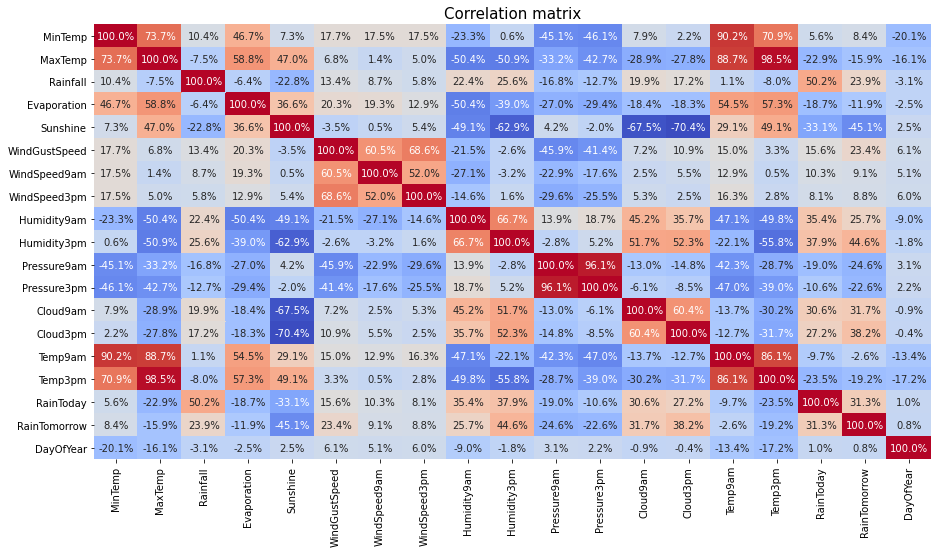

In [14]:
numeric_data_vizualization(data, histograms=False, boxplots=False, correlation=True)

## 5. Dealing with missing data

Missing data for variables [%]

In [15]:
round(data.isna().sum()/len(data)*100,2)

Date              0.00
Location          0.00
MinTemp           1.02
MaxTemp           0.87
Rainfall          2.24
Evaporation      43.17
Sunshine         48.01
WindGustDir       7.10
WindGustSpeed     7.06
WindDir9am        7.26
WindDir3pm        2.91
WindSpeed9am      1.21
WindSpeed3pm      2.11
Humidity9am       1.82
Humidity3pm       3.10
Pressure9am      10.36
Pressure3pm      10.33
Cloud9am         38.42
Cloud3pm         40.81
Temp9am           1.21
Temp3pm           2.48
RainToday         2.24
RainTomorrow      2.25
DayOfYear         0.00
dtype: float64

### Droping variables

Functions that will help to check number of missing values for locations

In [16]:
def check_missing_data_for_location(data, list_name_col, percent=5):
    
    df_of_location = pd.DataFrame({'location': [],
                                   'variable': [],
                                   'size_of_NaN': [],
                                   'size_of_location': [],
                                   'percent_of_NaN':[]})
    
    for name_of_column in list_name_col:
        size_of_missing_data = data[name_of_column].isna().sum()
        size_of_data = data.shape
        percent_of_missing_all = round(size_of_missing_data/size_of_data[0]*100, 2)
        new_variable ={'location': 'ALL', 
                        'variable': name_of_column, 
                        'size_of_NaN': size_of_missing_data,
                        'size_of_location': size_of_data[0],
                        'percent_of_NaN': f'{percent_of_missing_all}%'} 
        df_of_location = df_of_location.append(new_variable, ignore_index=True)
        
        for i in data.Location.unique():
            size_of_missing_data_in_location = data.loc[(data.Location==i) & (data[name_of_column].isna())].shape
            size_of_location = data.loc[data.Location==i].shape
            percent_of_missing = round(size_of_missing_data_in_location[0]/size_of_location[0]*100, 2)
            if percent_of_missing > percent:
                precent_of_NaN_for_all_NaN = round(size_of_missing_data_in_location[0]/size_of_missing_data*100, 2)
                new_location = {'location': i, 
                                'variable': name_of_column, 
                                'size_of_NaN': size_of_missing_data_in_location[0],
                                'size_of_location': size_of_location[0],
                                'percent_of_NaN': f'{percent_of_missing}%',
                                'precent_of_NaN_for_all_NaN': f'{precent_of_NaN_for_all_NaN}%'}
                df_of_location = df_of_location.append(new_location, ignore_index=True)
    return df_of_location

In [17]:
def eliminated_locations_and_variables(df):
    missing = check_missing_data_for_location(df, df.columns, percent=99.99)
    print('Number of locations with 100% missing values for variable:')
    variab = missing.variable[missing.location != 'ALL'].value_counts()
    print(variab,'\n',f'{len(variab)} variables')
    
    print('\n\nNumber of variables with 100% missing values for locations:')
    locat = missing.location[missing.location != 'ALL'].value_counts()
    print(locat)
    print(f'{len(locat)} locations')
    return missing

In [18]:
missing_all_variables_list100 = eliminated_locations_and_variables(data)


Number of locations with 100% missing values for variable:
Sunshine         19
Evaporation      16
Cloud9am         12
Cloud3pm         12
Pressure3pm       4
Pressure9am       4
WindGustDir       2
WindGustSpeed     2
Name: variable, dtype: int64 
 8 variables


Number of variables with 100% missing values for locations:
Penrith          6
MountGinini      6
Newcastle        6
SalmonGums       6
Nhil             4
NorahHead        4
Witchcliffe      4
Walpole          4
Tuggeranong      4
BadgerysCreek    4
GoldCoast        4
Adelaide         2
Albury           2
Uluru            2
Dartmoor         2
Albany           2
Ballarat         2
Wollongong       2
Launceston       1
PearceRAAF       1
Richmond         1
Bendigo          1
Katherine        1
Name: location, dtype: int64
23 locations


Deleting all missing data will eliminate 23 locations out of 49

In [19]:
def size_of_data_without_cutted_data(list_of_dfs=[],len_of_all_data=len(data),lamo=False,lamo_list=None,df=None):

    df_sizes = pd.DataFrame({'Name_of_dataframe/number_of_variables':[],
                           'What_was_cutted/what_was_changed':[],
                           'Size_of_data_without_cutted':[],
                            'Percent_of_samples':[]})
    if lamo == True:
        for z in lamo_list:
            sh = df.drop(axis=1, columns=z).dropna().shape[0]

            list_of_dfs.append((sh,z))

    
    for i, j in list_of_dfs:
        callers_local_vars = inspect.currentframe().f_back.f_locals.items()
        if type(i) == int:
            shape_cutted = int(i)
            if type(j) == str:
                name = int(1)
            else: name = int(len(j))

        else: 
            shape_cutted = i.shape[0]
            name = [var_name for var_name, var_val in callers_local_vars if var_val is i][0]
        df_sizes = df_sizes.append({'Name_of_dataframe/number_of_variables': name,
                         'What_was_cutted/what_was_changed': j,
                         'Size_of_data_without_cutted':shape_cutted,
                         'Percent_of_samples':f'{round(shape_cutted/len(data)*100, 2)}%'}, ignore_index=True)
    
    return df_sizes

Data with full original values

In [20]:
df_full = data.dropna()

Check how first deleting variables or lists of variables, then drop all NaNs will change a size of data

Variables with 100% missing data for some locations:

In [21]:
a = missing_all_variables_list100.variable[missing_all_variables_list100.location != 'ALL'].value_counts().index
a

Index(['Sunshine', 'Evaporation', 'Cloud9am', 'Cloud3pm', 'Pressure3pm',
       'Pressure9am', 'WindGustDir', 'WindGustSpeed'],
      dtype='object')

In [22]:
b = a.to_list()
b.append(a[:2].to_list())
b.append(a[:4].to_list())
b.append(a[:6].to_list())
b.append(a.to_list())
b

['Sunshine',
 'Evaporation',
 'Cloud9am',
 'Cloud3pm',
 'Pressure3pm',
 'Pressure9am',
 'WindGustDir',
 'WindGustSpeed',
 ['Sunshine', 'Evaporation'],
 ['Sunshine', 'Evaporation', 'Cloud9am', 'Cloud3pm'],
 ['Sunshine',
  'Evaporation',
  'Cloud9am',
  'Cloud3pm',
  'Pressure3pm',
  'Pressure9am'],
 ['Sunshine',
  'Evaporation',
  'Cloud9am',
  'Cloud3pm',
  'Pressure3pm',
  'Pressure9am',
  'WindGustDir',
  'WindGustSpeed']]

In [23]:
c = size_of_data_without_cutted_data([(df_full,'All missing data')],lamo=True,lamo_list=b,df=data)
c

,Name_of_dataframe/number_of_variables,What_was_cutted/what_was_changed,Size_of_data_without_cutted,Percent_of_samples
0,df_full,All missing data,56420.0,38.79%
1,1,Sunshine,61981.0,42.61%
2,1,Evaporation,58278.0,40.06%
3,1,Cloud9am,56613.0,38.92%
4,1,Cloud3pm,57806.0,39.74%
5,1,Pressure3pm,56437.0,38.8%
6,1,Pressure9am,56452.0,38.81%
7,1,WindGustDir,56429.0,38.79%
8,1,WindGustSpeed,56420.0,38.79%
9,2,"[Sunshine, Evaporation]",71045.0,48.84%


Data with deleted all missing data is 38.79%
Data with deleted variables: Sunshine, Evaporation, Cloud3pm, Cloud9am then deleted missing data is 77.63%
It's 38.84% more data.
The rest of variables don't pay off to cut, because deleting Pressure9am, Pressure3pm will get only 6.1% of data and deleting WindGustDir, WindGustSpeed will get next only 3.6%

In [24]:
df_SECC_n = data.drop(axis=1, columns=['Sunshine','Evaporation','Cloud3pm','Cloud9am'])

In [25]:
missing100_df_SECC = eliminated_locations_and_variables(df_SECC_n)

Number of locations with 100% missing values for variable:
Pressure9am      4
Pressure3pm      4
WindGustSpeed    2
WindGustDir      2
Name: variable, dtype: int64 
 4 variables


Number of variables with 100% missing values for locations:
Newcastle      4
Albany         2
Penrith        2
SalmonGums     2
MountGinini    2
Name: location, dtype: int64
5 locations


In [26]:
missing100_df_SECC

,location,variable,size_of_NaN,size_of_location,percent_of_NaN,precent_of_NaN_for_all_NaN
0,ALL,Date,0.0,145460.0,0.0%,NaN
1,ALL,Location,0.0,145460.0,0.0%,NaN
2,ALL,MinTemp,1485.0,145460.0,1.02%,NaN
3,ALL,MaxTemp,1261.0,145460.0,0.87%,NaN
4,ALL,Rainfall,3261.0,145460.0,2.24%,NaN
5,ALL,WindGustDir,10326.0,145460.0,7.1%,NaN
6,Newcastle,WindGustDir,3039.0,3039.0,100.0%,29.43%
7,Albany,WindGustDir,3040.0,3040.0,100.0%,29.44%
8,ALL,WindGustSpeed,10263.0,145460.0,7.06%,NaN
9,Newcastle,WindGustSpeed,3039.0,3039.0,100.0%,29.61%


Deleting all missing data after deleting variables (Sunshine, Evaporation, Cloud3pm, Cloud9am) will eliminate 5 locations out of 49

In [27]:
a = missing100_df_SECC.variable[missing100_df_SECC.location != 'ALL'].value_counts().index
a

Index(['Pressure9am', 'Pressure3pm', 'WindGustSpeed', 'WindGustDir'], dtype='object')

In [28]:
b = a.to_list()
b.append(a[:2].to_list())
b.append(a[2:].to_list())
b.append(a.to_list())
b

['Pressure9am',
 'Pressure3pm',
 'WindGustSpeed',
 'WindGustDir',
 ['Pressure9am', 'Pressure3pm'],
 ['WindGustSpeed', 'WindGustDir'],
 ['Pressure9am', 'Pressure3pm', 'WindGustSpeed', 'WindGustDir']]

In [29]:
df_SECC = df_SECC_n.dropna()

In [30]:
lista = [(df_full, 'All missing data'),
         (df_SECC, ['Sunshine','Evaporation','Cloud3pm','Cloud9am'])]

In [31]:
size_of_data_without_cutted_data(lista, lamo=True, lamo_list=b, df=df_SECC_n)

,Name_of_dataframe/number_of_variables,What_was_cutted/what_was_changed,Size_of_data_without_cutted,Percent_of_samples
0,df_full,All missing data,56420.0,38.79%
1,df_SECC,"[Sunshine, Evaporation, Cloud3pm, Cloud9am]",112925.0,77.63%
2,1,Pressure9am,113011.0,77.69%
3,1,Pressure3pm,112960.0,77.66%
4,1,WindGustSpeed,112925.0,77.63%
5,1,WindGustDir,112938.0,77.64%
6,2,"[Pressure9am, Pressure3pm]",121790.0,83.73%
7,2,"[WindGustSpeed, WindGustDir]",117068.0,80.48%
8,4,"[Pressure9am, Pressure3pm, WindGustSpeed, Wind...",127033.0,87.33%


It doesn't pay off to cut more variables

### Different approach to dealing with missing data

In [32]:
miss=data.isna().sum()/len(data)*100
round(miss,2)

Date              0.00
Location          0.00
MinTemp           1.02
MaxTemp           0.87
Rainfall          2.24
Evaporation      43.17
Sunshine         48.01
WindGustDir       7.10
WindGustSpeed     7.06
WindDir9am        7.26
WindDir3pm        2.91
WindSpeed9am      1.21
WindSpeed3pm      2.11
Humidity9am       1.82
Humidity3pm       3.10
Pressure9am      10.36
Pressure3pm      10.33
Cloud9am         38.42
Cloud3pm         40.81
Temp9am           1.21
Temp3pm           2.48
RainToday         2.24
RainTomorrow      2.25
DayOfYear         0.00
dtype: float64

To replace data first there is a need to drop missing data from the target variable and the variable from  which is made. 

In [33]:
df_new = data.dropna(subset = ['RainTomorrow','RainToday'])

In [34]:
miss=df_new.isna().sum()/len(df_new)*100
round(miss,2)

Date              0.00
Location          0.00
MinTemp           0.33
MaxTemp           0.22
Rainfall          0.00
Evaporation      42.40
Sunshine         47.45
WindGustDir       6.51
WindGustSpeed     6.47
WindDir9am        6.86
WindDir3pm        2.61
WindSpeed9am      0.75
WindSpeed3pm      1.80
Humidity9am       1.08
Humidity3pm       2.49
Pressure9am       9.76
Pressure3pm       9.78
Cloud9am         37.38
Cloud3pm         39.84
Temp9am           0.47
Temp3pm           1.86
RainToday         0.00
RainTomorrow      0.00
DayOfYear         0.00
dtype: float64

To replace missing data first is need to split data for train and test sets

Due data is time series, data need to be split by date. Cut-off date is 01-01-2016

In [203]:
Cut_off = '01.01.2016'
df_train_full = df_full[df_full.Date <= Cut_off]
df_test_full = df_full[df_full.Date > Cut_off]

In [204]:
df_train_SECC = df_SECC[df_SECC.Date <= Cut_off]
df_test_SECC = df_SECC[df_SECC.Date > Cut_off]

In [205]:
df_train_new = df_new[df_new.Date <= Cut_off]
df_test_new = df_new[df_new.Date > Cut_off]

Replacement missing data with mode:

In [206]:
df_train_mode = df_train_new.copy()
df_test_mode = df_test_new.copy()
for i in df_train_mode.columns:
    m = df_train_mode[i].mode()[0]
    df_train_mode[i].fillna(m, inplace = True)
    df_test_mode[i].fillna(m, inplace = True)


Replacement missing data for object variables by random sample of items from values for each column.
Replacement missing data for numeric variables by mean and median.

In [207]:
df_train_mean = df_train_new.copy()
df_test_mean = df_test_new.copy()

df_train_median = df_train_new.copy()
df_test_median = df_test_new.copy()

for i in df_train_mean.columns:
    if df_train_mean[i].dtype == 'O':
        
        df_train_mean[i][np.array(df_train_mean[i].isna())] = np.array(df_train_mean[i][~df_train_mean[i].isna()].sample(df_train_mean[i].isna().sum()))
        df_test_mean[i][np.array(df_test_mean[i].isna())] = np.array(df_train_mean[i][~df_train_mean[i].isna()].sample(df_test_mean[i].isna().sum()))
        df_train_median[i][np.array(df_train_median[i].isna())] = np.array(df_train_median[i][~df_train_median[i].isna()].sample(df_train_median[i].isna().sum()))
        df_test_median[i][np.array(df_test_median[i].isna())] = np.array(df_train_median[i][~df_train_median[i].isna()].sample(df_test_median[i].isna().sum()))
        
    else:
        df_train_mean[i].fillna(df_train_mean[i].mean(), inplace=True)
        df_test_mean[i].fillna(df_train_mean[i].mean(), inplace=True)
        df_train_median[i].fillna(df_train_median[i].median(), inplace=True)
        df_test_median[i].fillna(df_train_median[i].median(), inplace=True)


Replacement missing data for variables by random sample of items from values for each month for each column.

In [208]:
df_train_M = df_train_new.copy()
df_test_M = df_test_new.copy()

In [209]:
df_train_M["Month"] = df_train_M.Date.dt.month
df_test_M["Month"] = df_test_M.Date.dt.month

In [210]:
for i in df_train_M.columns:
    for j in df_train_M.Month.unique():
        df_train_M[i][np.array((df_train_M[i].isna()) & (df_train_M.Month == j))] = np.array(df_train_M[i][(~df_train_M[i].isna()) & (df_train_M.Month == j)].sample(((df_train_M[i].isna()) & (df_train_M.Month == j)).sum()))
        df_test_M[i][np.array((df_test_M[i].isna()) & (df_test_M.Month == j))] = np.array(df_train_M[i][(~df_train_M[i].isna()) & (df_train_M.Month == j)].sample(((df_test_M[i].isna()) & (df_test_M.Month == j)).sum()))

Finally size of all DataFrames and percent of samples from original data

In [43]:
list_of_all_dfs = [(df_full, 'All missing data'),
         (df_SECC, ['Sunshine','Evaporation','Cloud3pm','Cloud9am']),
         (df_new, f"dropna in {['RainToday','RainTomorrow']}")]

In [44]:
size_of_data_without_cutted_data(list_of_all_dfs, lamo=False)

,Name_of_dataframe/number_of_variables,What_was_cutted/what_was_changed,Size_of_data_without_cutted,Percent_of_samples
0,df_full,All missing data,56420.0,38.79%
1,df_SECC,"[Sunshine, Evaporation, Cloud3pm, Cloud9am]",112925.0,77.63%
2,df_new,"dropna in ['RainToday', 'RainTomorrow']",140787.0,96.79%


df_new reprezentate all filled sets in different ways

### Vizualizaton of changed data

Below figures shows arrangement of data for different data preparation

In [45]:
def dateforlocation(df_train_X,df_test_X):
    plt.figure(figsize=(15,4))
    plt.scatter(df_train_X.Location,df_train_X.Date, marker='.',c='k', label = 'train')
    plt.scatter(df_test_X.Location,df_test_X.Date, marker='.', label = 'test')
    plt.xticks(rotation=90)
    plt.legend()
    plt.title('Date for Locations',fontsize=15)
    plt.show()


DataFrame with dropped all missing data:

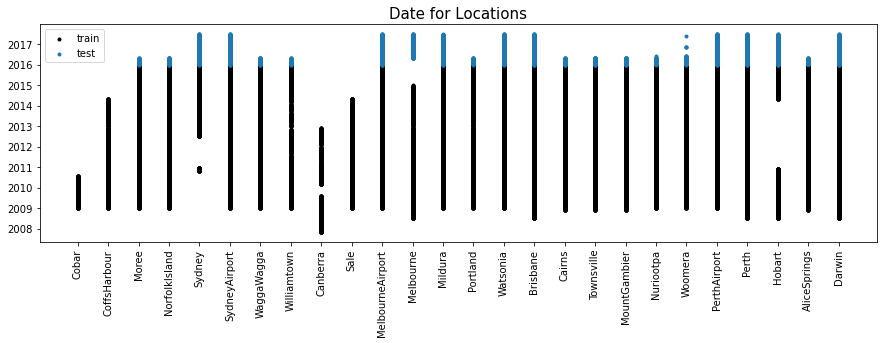

In [46]:
dateforlocation(df_train_full,df_test_full)

DataFrame with dropped all missing data after deleting variables (Sunshine, Evaporation, Cloud3pm, Cloud9am):

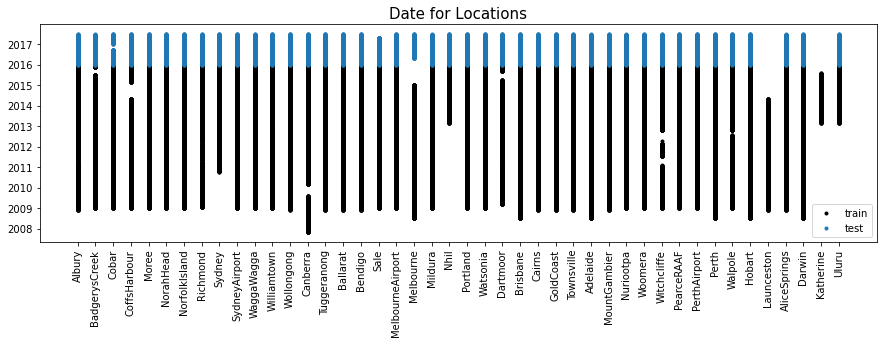

In [47]:
dateforlocation(df_train_SECC,df_test_SECC)

Representation of DataFrames (df_mode, df_median, df_mean, df_M) with dropped Rain missing values:

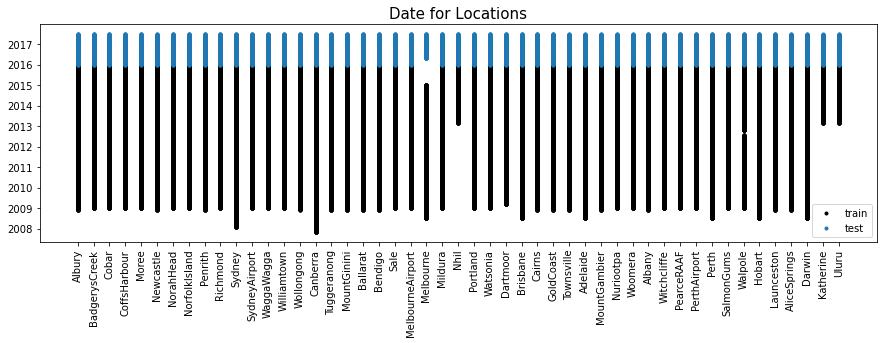

In [48]:
dateforlocation(df_train_new,df_test_new)

Below figures shows wind directions for train sets:

DataFrame with dropped all missing data:

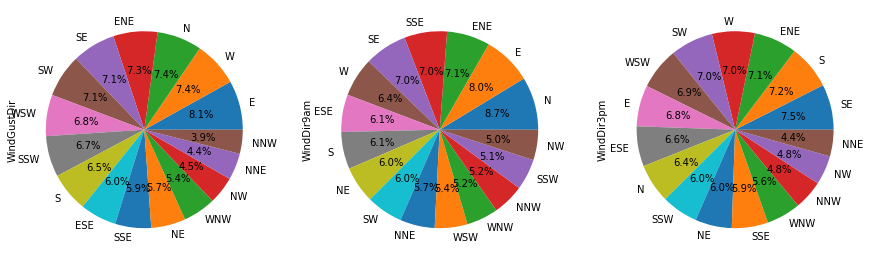

In [49]:
object_data_vizualization(df_train_full, date_location=False, wind=True, rain=False)

DataFrame with missing data filled by mode:

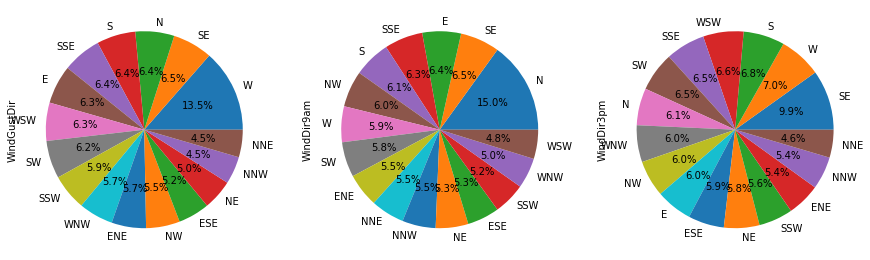

In [50]:
object_data_vizualization(df_train_mode, date_location=False, wind=True, rain=False)

Representation of DataFrames filled by random sample of items from values for wind.

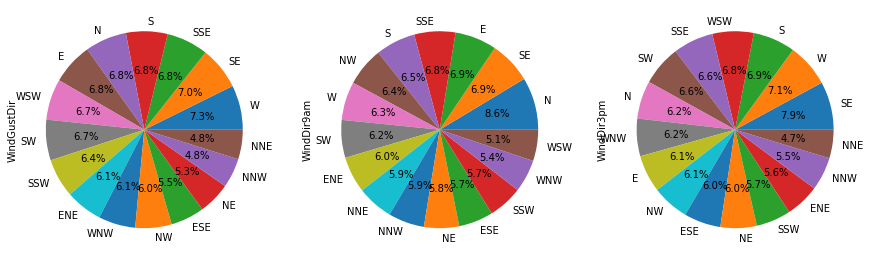

In [51]:
object_data_vizualization(df_train_mean, date_location=False, wind=True, rain=False)

DataFrames filled by random sample of items from values for wind for each month.

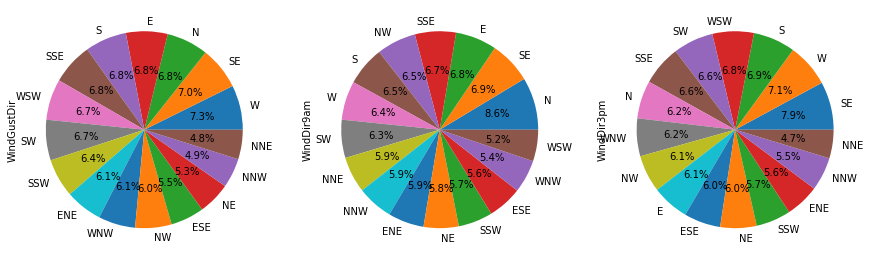

In [52]:
object_data_vizualization(df_train_M, date_location=False, wind=True, rain=False)

Numeric data distribution for different data preparation

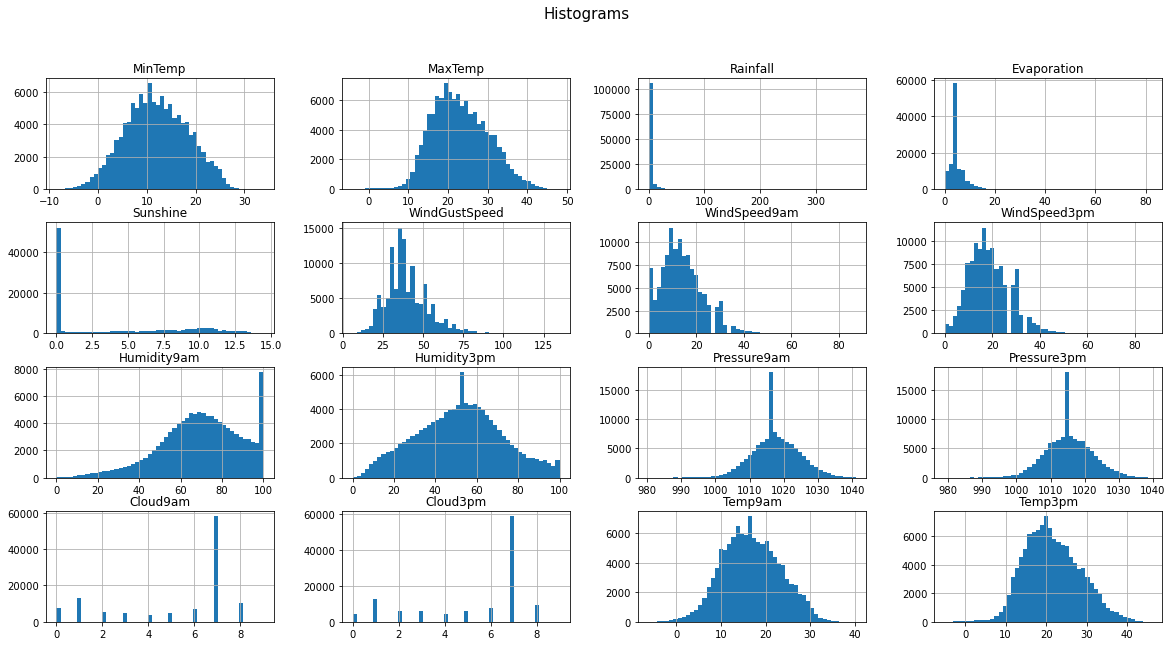

In [53]:
numeric_data_vizualization(df_train_mode, histograms=True, boxplots=False, correlation=False)

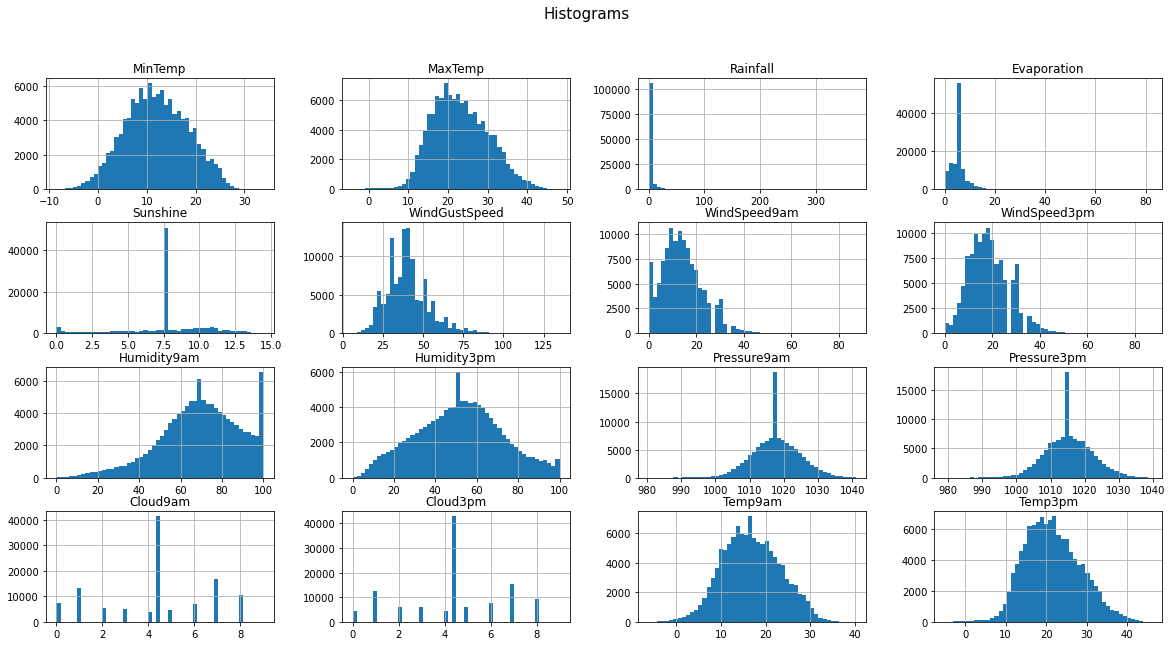

In [54]:
numeric_data_vizualization(df_train_mean, histograms=True, boxplots=False, correlation=False)

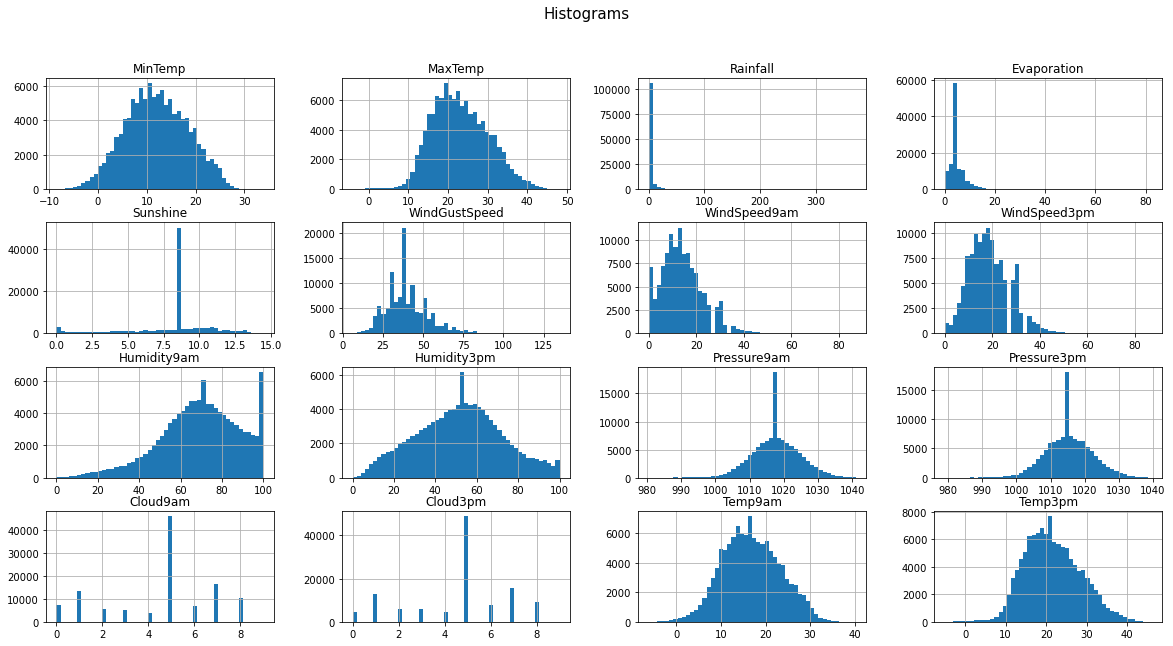

In [55]:
numeric_data_vizualization(df_train_median, histograms=True, boxplots=False, correlation=False)

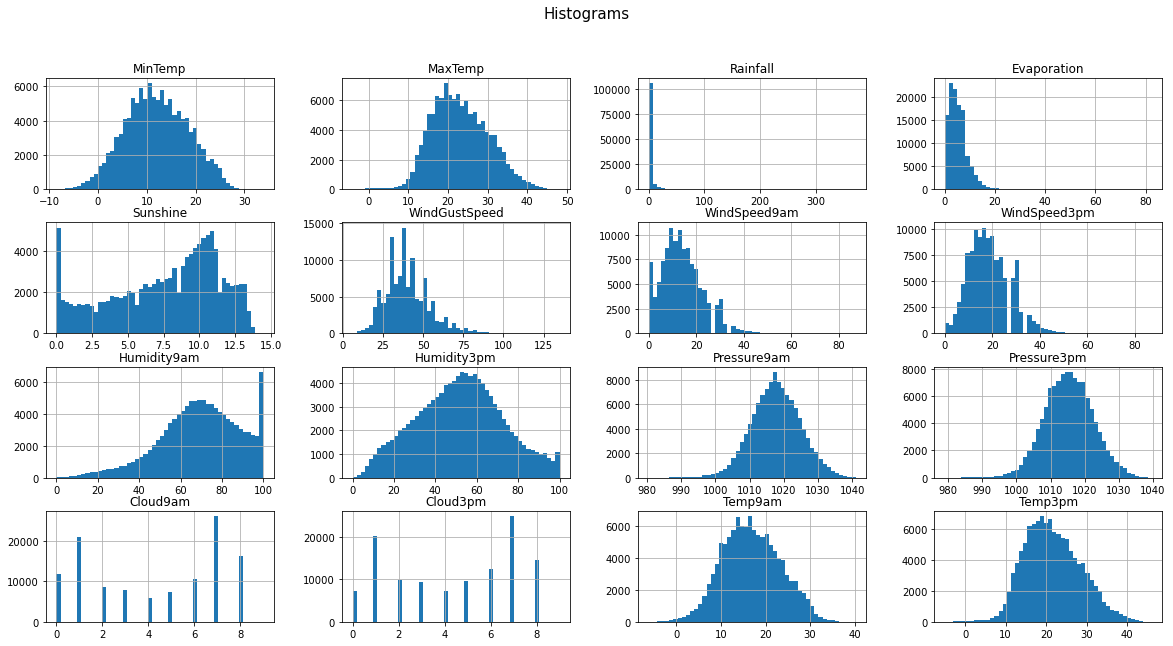

In [56]:
numeric_data_vizualization(df_train_M, histograms=True, boxplots=False, correlation=False)

Ratio of target variable

In [57]:
def ratio_of_y(Rain):
    rain_count = Rain.value_counts()
    print(rain_count)
    rain_count.plot(kind='bar', color=['g','b'], rot=0)
    plt.title('RainTomorrow values ratio 1(Yes) and 0(No)')
    plt.show()
    print(f'Percent of No:\t{round(rain_count[0]/rain_count.sum()*100, 2)}%')
    print(f'Percent of Yes:\t{round(rain_count[1]/rain_count.sum()*100, 2)}%')


0.0    110316
1.0     31877
Name: RainTomorrow, dtype: int64


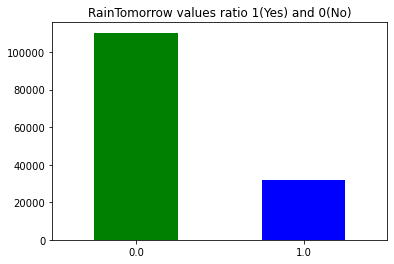

Percent of No:	77.58%
Percent of Yes:	22.42%


In [58]:
ratio_of_y(data.RainTomorrow)

0.0    39156
1.0    11000
Name: RainTomorrow, dtype: int64


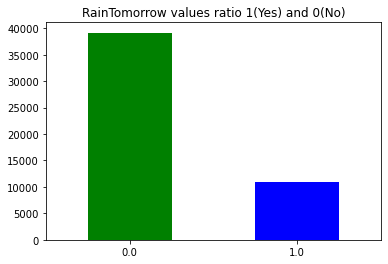

Percent of No:	78.07%
Percent of Yes:	21.93%


In [59]:
ratio_of_y(df_train_full.RainTomorrow)

0.0    4837
1.0    1427
Name: RainTomorrow, dtype: int64


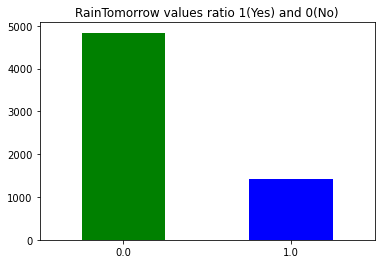

Percent of No:	77.22%
Percent of Yes:	22.78%


In [60]:
ratio_of_y(df_test_full.RainTomorrow)

0.0    72208
1.0    20340
Name: RainTomorrow, dtype: int64


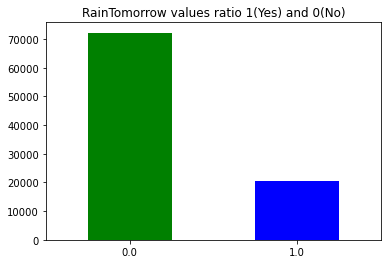

Percent of No:	78.02%
Percent of Yes:	21.98%


In [61]:
ratio_of_y(df_train_SECC.RainTomorrow)

0.0    89742
1.0    25380
Name: RainTomorrow, dtype: int64


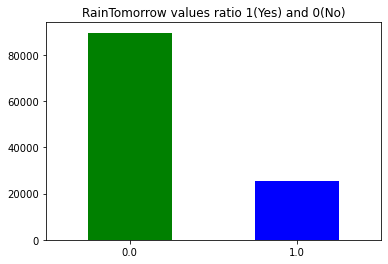

Percent of No:	77.95%
Percent of Yes:	22.05%


In [62]:
ratio_of_y(df_train_M.RainTomorrow)

Data is imbalanced

## 6. Final data preparation

Final data preparation:
- separate target,
- dropping column with Date,
- dropping column with location and/or month (optional)
- encoding object variables

In [63]:
def Xy_preparation(df, location_off=True, months=False):
    
    y = df.RainTomorrow
    X = df.drop(columns=['RainTomorrow','Date'])
    if months == True:
        X.drop(columns='Month', inplace=True)
    if location_off == True:
        X.drop(columns='Location', inplace=True)
    return X, y

In [64]:
def final_preparation(df_train_X,df_test_X, location_off=True, months=False):
    
    df_train_X.sort_values('Date', inplace=True)
    
    X_train, y_train = Xy_preparation(df_train_X, location_off=location_off, months=months)
    X_train = pd.get_dummies(X_train)
    
    X_test, y_test = Xy_preparation(df_test_X, location_off=location_off, months=months)
    X_test = pd.get_dummies(X_test)
    X_train, X_test = X_train.align(X_test, join='left', axis=1)
    X_test.fillna(0,inplace=True)
    print(f'X_train shape:\t{X_train.shape}\nX_test shape:\t{X_test.shape}')
    return X_train, X_test, y_train, y_test

In [211]:
X_train_full, X_test_full, y_train_full,y_test_full = final_preparation(df_train_full,df_test_full, location_off=False)

X_train shape:	(50156, 92)
X_test shape:	(6264, 92)


In [212]:
X_train_full_l, X_test_full_l, y_train_full_l, y_test_full_l = final_preparation(df_train_full,df_test_full, location_off=True)

X_train shape:	(50156, 66)
X_test shape:	(6264, 66)


In [213]:
X_train_SECC, X_test_SECC, y_train_SECC, y_test_SECC = final_preparation(df_train_SECC,df_test_SECC, location_off=False)

X_train shape:	(92548, 106)
X_test shape:	(20377, 106)


In [214]:
X_train_SECC_l, X_test_SECC_l, y_train_SECC_l, y_test_SECC_l = final_preparation(df_train_SECC,df_test_SECC, location_off=True)

X_train shape:	(92548, 62)
X_test shape:	(20377, 62)


In [215]:
X_train_mode, X_test_mode, y_train_mode, y_test_mode = final_preparation(df_train_mode,df_test_mode, location_off=False)

X_train shape:	(115122, 115)
X_test shape:	(25665, 115)


In [216]:
X_train_mode_l, X_test_mode_l, y_train_mode_l, y_test_mode_l = final_preparation(df_train_mode,df_test_mode, location_off=True)

X_train shape:	(115122, 66)
X_test shape:	(25665, 66)


In [217]:
X_train_mean, X_test_mean, y_train_mean, y_test_mean = final_preparation(df_train_mean,df_test_mean, location_off=False)

X_train shape:	(115122, 115)
X_test shape:	(25665, 115)


In [218]:
X_train_mean_l, X_test_mean_l, y_train_mean_l, y_test_mean_l = final_preparation(df_train_mean,df_test_mean, location_off=True)

X_train shape:	(115122, 66)
X_test shape:	(25665, 66)


In [219]:
X_train_median, X_test_median, y_train_median, y_test_median = final_preparation(df_train_median,df_test_median, location_off=False)

X_train shape:	(115122, 115)
X_test shape:	(25665, 115)


In [220]:
X_train_median_l, X_test_median_l, y_train_median_l, y_test_median_l = final_preparation(df_train_median,df_test_median, location_off=True)

X_train shape:	(115122, 66)
X_test shape:	(25665, 66)


In [221]:
X_train_M, X_test_M, y_train_M, y_test_M = final_preparation(df_train_M,df_test_M, location_off=False, months=True)

X_train shape:	(115122, 115)
X_test shape:	(25665, 115)


In [222]:
X_train_M_l, X_test_M_l, y_train_M_l, y_test_M_l = final_preparation(df_train_M,df_test_M, location_off=True, months=True)

X_train shape:	(115122, 66)
X_test shape:	(25665, 66)


To be able to compare different data preparation, there is need to take the same samples for test. The smalest set is with samples contains full of data. 

Rest of samples are filled data in different ways. It's need to be different comparison.

In [223]:
idx = X_test_full.index

In [79]:
def the_same_samles(idx, X_test, y_test):
    X_test_2 = X_test.loc[X_test.index.difference(idx)]
    y_test_2 = y_test.loc[X_test.index.difference(idx)]
    X_test = X_test.loc[idx]
    y_test = y_test.loc[idx]
    return X_test, y_test, X_test_2, y_test_2

In [224]:
X_test_SECC, y_test_SECC, X_test_SECC2, y_test_SECC2 = the_same_samles(idx, X_test_SECC, y_test_SECC)
X_test_SECC_l, y_test_SECC_l, X_test_SECC_l2, y_test_SECC_l2 = the_same_samles(idx, X_test_SECC_l, y_test_SECC_l)
X_test_mode, y_test_mode, X_test_mode2, y_test_mode2 = the_same_samles(idx, X_test_mode, y_test_mode)
X_test_mode_l, y_test_mode_l, X_test_mode_l2, y_test_mode_l2 = the_same_samles(idx, X_test_mode_l, y_test_mode_l)
X_test_mean, y_test_mean, X_test_mean2, y_test_mean2 = the_same_samles(idx, X_test_mean, y_test_mean)
X_test_mean_l, y_test_mean_l, X_test_mean_l2, y_test_mean_l2 = the_same_samles(idx, X_test_mean_l, y_test_mean_l)
X_test_median, y_test_median, X_test_median2, y_test_median2 = the_same_samles(idx, X_test_median, y_test_median)
X_test_median_l, y_test_median_l, X_test_median_l2, y_test_median_l2 = the_same_samles(idx, X_test_median_l, y_test_median_l)
X_test_M, y_test_M, X_test_M2, y_test_M2 = the_same_samles(idx, X_test_M, y_test_M)
X_test_M_l, y_test_M_l, X_test_M_l2, y_test_M_l2 = the_same_samles(idx, X_test_M_l, y_test_M_l)


## 7. Model training

Looking for the best model:

In [81]:
def pipel (df_X, df_y, model, search):
    pipeline = imbPipeline(model)
    param_grid = search
    optimizer = GridSearchCV(pipeline,param_grid,cv=TimeSeriesSplit(), scoring='f1',n_jobs=-1)
    optimizer.fit(df_X, df_y)
    return optimizer


In [82]:
def logreg(df_X,df_y,scaler=StandardScaler()):
    model = [('smote', SMOTE(random_state=42)),
             ('scaler', scaler),
             ('model', LogisticRegression(random_state=42))]
    search = [{'model__penalty':['none']},
          {'model__C':[1,10,100],
          'model__penalty':['l2']},
          {'model__penalty':['l1'],
          'model__solver':['saga','liblinear'],
          'model__C':[0.1,10,100]}]
    return pipel(df_X,df_y,model,search)


In [312]:
def DTreeC(df_X,df_y,scaler=StandardScaler()):
    model = [('smote', SMOTE(random_state=42)),
             ('scaler',scaler),
             ('model', DecisionTreeClassifier(random_state=42))]
    search = [{'model__max_depth':[15,20],
          'model__max_features':['auto','sqrt'],
          'model__min_samples_leaf':[2,10,20]}]
    return pipel(df_X,df_y,model,search)


In [84]:
def RF(df_X,df_y,scaler=StandardScaler()):
    model = [('smote', SMOTE(random_state=42)),
             ('scaler', scaler),
             ('model', RandomForestClassifier(random_state=42))]
    search = [{'model__max_depth':[15,20],
              'model__max_features':['auto','sqrt'],
              'model__min_samples_leaf':[10,15],
              'model__n_estimators':[300]}]
    return pipel(df_X,df_y,model,search)


In [85]:
def BG(df_X, df_y, scaler=StandardScaler()):
    model = [('smote', SMOTE(random_state=42)),
             ('scaler', scaler),
             ('model', BaggingClassifier(DecisionTreeClassifier(random_state=42),random_state=42))]
    search = [{'model__n_estimators':[20,30],
              'model__max_samples':[0.7,0.3],
              'model__max_features':[0.7,0.3],
               'model__bootstrap':[True,False],
               'model__bootstrap_features':[True,False]
              }]
    return pipel(df_X,df_y,model,search)


In [86]:
def ETC(df_X, df_y, scaler=StandardScaler()):
    model = [('smote', SMOTE(random_state=42)),
             ('scaler', scaler),
             ('model', ExtraTreesClassifier(random_state=42))]
    search = [{'model__n_estimators':[300],
              'model__max_depth':[10,20],
              'model__min_samples_leaf':[10,20]
              }]
    return pipel(df_X,df_y,model,search)


In [87]:
def AB(df_X, df_y, scaler=StandardScaler()):
    model = [('smote', SMOTE(random_state=42)),
             ('scaler', scaler),
             ('model', AdaBoostClassifier(DecisionTreeClassifier(max_depth=20, max_features='auto',\
                                                            min_samples_leaf=2, random_state=42),random_state=42))]
    search = [{'model__n_estimators':[200],
              'model__learning_rate':[1,0.7,0.3],
              }]
    return pipel(df_X,df_y,model,search)


In [88]:
def XGB(df_X, df_y, scaler=StandardScaler()):
    model = [('smote', SMOTE(random_state=42)),
             ('scaler', scaler),
             ('model', XGBClassifier(random_state=42))]
    search = [{'model__n_estimators':[100],
               'model__max_depth':[20],
               'model__gamma':[0.7,0.3],
               'model__reg_alpha':[0,0.3],
               'model__reg_lambda':[0,0.2]
              }]
    return pipel(df_X,df_y,model,search)


In [89]:
scores_full = pd.DataFrame({'set':[],
                            'size_train':[],
                            'size_test':[],
                            'model':[],
                            'accuracy':[],
                            'f1_score':[]})

In [90]:
def report(optimizer, df_X_train, df_X_test, df_y_train, df_y_test):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    y_pred = optimizer.predict(df_X_test)
    train_shape = df_X_train.shape
    test_shape = df_X_test.shape
    acc = round(accuracy_score(df_y_test,y_pred),4)
    f_1 = round(f1_score(df_y_test,y_pred),4)
    estimator = optimizer.best_estimator_[2]
    print(estimator)
    newline = {'set':([var_name for var_name, var_val in callers_local_vars if var_val is df_X_train][0])[7:],
            'size_train':train_shape,
            'size_test':test_shape,
            'model':estimator,
            'accuracy':acc,
            'f1_score':f_1}
    return newline

In [91]:
start = time.time()
opt_logreg= logreg(X_train_full,y_train_full)
finish = time.time()-start
finish

324.1036162376404

In [92]:
scores_full = scores_full.append(report(opt_logreg,df_X_train=X_train_full, df_X_test=X_test_full, df_y_train=y_train_full, df_y_test=y_test_full),ignore_index=True)

LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')


In [313]:
start = time.time()
opt_DTC= DTreeC(X_train_full,y_train_full)
finish = time.time()-start
finish

34.80826735496521

In [314]:
scores_full = scores_full.append(report(opt_DTC,df_X_train=X_train_full, df_X_test=X_test_full, df_y_train=y_train_full, df_y_test=y_test_full),ignore_index=True)

DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)


In [95]:
start = time.time()
opt_RF= RF(X_train_full,y_train_full)
finish = time.time()-start
finish

328.56031107902527

In [96]:
scores_full = scores_full.append(report(opt_RF,df_X_train=X_train_full, df_X_test=X_test_full, df_y_train=y_train_full, df_y_test=y_test_full),ignore_index=True)

RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)


In [97]:
start = time.time()
opt_BG= BG(X_train_full,y_train_full)
finish = time.time()-start
finish


392.2975115776062

In [98]:
scores_full = scores_full.append(report(opt_BG,df_X_train=X_train_full, df_X_test=X_test_full, df_y_train=y_train_full, df_y_test=y_test_full),ignore_index=True)

BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, max_samples=0.3, n_estimators=30,
                  random_state=42)


In [99]:
start = time.time()
opt_ETC= ETC(X_train_full,y_train_full)
finish = time.time()-start
finish

149.59362816810608

In [100]:
scores_full = scores_full.append(report(opt_ETC,df_X_train=X_train_full, df_X_test=X_test_full, df_y_train=y_train_full, df_y_test=y_test_full),ignore_index=True)

ExtraTreesClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                     random_state=42)


In [101]:
start = time.time()
opt_AB= AB(X_train_full,y_train_full)
finish = time.time()-start
finish

267.7265923023224

In [102]:
scores_full = scores_full.append(report(opt_AB,df_X_train=X_train_full, df_X_test=X_test_full, df_y_train=y_train_full, df_y_test=y_test_full),ignore_index=True)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20,
                                                         max_features='auto',
                                                         min_samples_leaf=2,
                                                         random_state=42),
                   learning_rate=1, n_estimators=200, random_state=42)


In [103]:
start = time.time()
opt_XGB= XGB(X_train_full,y_train_full)
finish = time.time()-start
finish

C:\Users\katar\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23:50:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


975.0900695323944

In [104]:
scores_full = scores_full.append(report(opt_XGB,df_X_train=X_train_full, df_X_test=X_test_full, df_y_train=y_train_full, df_y_test=y_test_full),ignore_index=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0.2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [319]:
scores_full

,set,size_train,size_test,model,accuracy,f1_score
0,_full,"(50156, 92)","(6264, 92)","LogisticRegression(C=0.1, penalty='l1', random...",0.8370,0.5868
1,_full,"(50156, 92)","(6264, 92)","DecisionTreeClassifier(max_depth=20, max_featu...",0.7791,0.5631
2,_full,"(50156, 92)","(6264, 92)","(DecisionTreeClassifier(max_depth=20, max_feat...",0.8276,0.6386
3,_full,"(50156, 92)","(6264, 92)",(DecisionTreeClassifier(random_state=195292617...,0.8370,0.6214
4,_full,"(50156, 92)","(6264, 92)","(ExtraTreeClassifier(max_depth=20, min_samples...",0.8202,0.6296
5,_full,"(50156, 92)","(6264, 92)","(DecisionTreeClassifier(max_depth=20, max_feat...",0.8424,0.6329
6,_full,"(50156, 92)","(6264, 92)","XGBClassifier(base_score=0.5, booster='gbtree'...",0.8386,0.6092


In [106]:
scores_full.sort_values('f1_score',ascending=False)

,set,size_train,size_test,model,accuracy,f1_score
2,_full,"(50156, 92)","(6264, 92)","(DecisionTreeClassifier(max_depth=20, max_feat...",0.8276,0.6386
5,_full,"(50156, 92)","(6264, 92)","(DecisionTreeClassifier(max_depth=20, max_feat...",0.8424,0.6329
4,_full,"(50156, 92)","(6264, 92)","(ExtraTreeClassifier(max_depth=20, min_samples...",0.8202,0.6296
3,_full,"(50156, 92)","(6264, 92)",(DecisionTreeClassifier(random_state=195292617...,0.8370,0.6214
6,_full,"(50156, 92)","(6264, 92)","XGBClassifier(base_score=0.5, booster='gbtree'...",0.8386,0.6092
0,_full,"(50156, 92)","(6264, 92)","LogisticRegression(C=0.1, penalty='l1', random...",0.8370,0.5868
1,_full,"(50156, 92)","(6264, 92)","DecisionTreeClassifier(max_depth=20, max_featu...",0.7791,0.5631


To be able to compare different data preparation methods, it is necessary to use the same models for different data preparation

In [225]:
def model( df_X_train, df_X_test, df_y_train, df_y_test, df_X_test2, df_y_test2, estimator,scaler=True, smote=True):
    if smote == True:
        smt = SMOTE(random_state=42)
        df_X_train, df_y_train = smt.fit_resample(df_X_train,df_y_train)
    if scaler == True:
        sc = StandardScaler()
        df_X_train = sc.fit_transform(df_X_train)
        df_X_test = sc.transform(df_X_test)
        df_X_test2 = sc.transform(df_X_test2)
    mod = estimator
    mod.fit(df_X_train,df_y_train)
    y_pred = mod.predict(df_X_test)
    y_pred2 = mod.predict(df_X_test2)
    f_1 = f1_score(df_y_test,y_pred)
    acc = accuracy_score(df_y_test,y_pred)
    f_12 = f1_score(df_y_test2,y_pred2)
    acc2 = accuracy_score(df_y_test2,y_pred2)
    print(f'f1: {round(f_1,4)} \nacc: {round(acc,4)}')
    return mod, f_1, acc, sc, f_12, acc2
    

In [226]:
def report_m(m, f_1, acc, df_X_train, df_X_test,name):
    train_shape = df_X_train.shape
    test_shape = df_X_test.shape
    estimator = m
    print(estimator)
    newline = {'set':name,
            'size_train':train_shape,
            'size_test':test_shape,
            'model':estimator,
            'accuracy':round(acc,4),
            'f1_score':round(f_1,4)}
    return newline

In [227]:
def train_list_of_models(scores,df_X_train, df_X_test, df_y_train, df_y_test, df_X_test2, df_y_test2,name,scaler=True):
    scores_new = pd.DataFrame({'set':[],
                      'size_train':[],
                      'size_test':[],
                      'model':[],
                      'accuracy':[],
                      'f1_score':[]})
    scores_replaced = pd.DataFrame({'set':[],
                  'size_train':[],
                  'size_test':[],
                  'model':[],
                  'accuracy':[],
                  'f1_score':[]})
    models_new = list()

    for i in scores.model:
        
        ml,f_1,acc,sc,f_12, acc2= model(df_X_train, df_X_test, df_y_train, df_y_test, df_X_test2, df_y_test2, estimator=i,scaler=scaler)
        models_new.append(ml)
        scores_new = scores_new.append(report_m(ml,f_1,acc,df_X_train, df_X_test,name),ignore_index=True)
        scores_replaced = scores_replaced.append(report_m(ml,f_12,acc2,df_X_train, df_X_test2,name),ignore_index=True)
    return scores_new, models_new, scores_replaced

In [228]:
scores_full_l, models_full_l, _ = train_list_of_models(scores_full,X_train_full_l, X_test_full_l, y_train_full_l, y_test_full_l,X_test_full_l,y_test_full_l,'_full_l',scaler=True)

f1: 0.5851 
acc: 0.836
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
f1: 0.5663 
acc: 0.7733
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
f1: 0.6367 
acc: 0.8271
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
f1: 0.6042 
acc: 0.8295
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, max_samples=0.3, n_estimators=30,
                  random_state=42)
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, ma

C:\Users\katar\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1: 0.6005 
acc: 0.8354
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0.2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         

In [231]:
scores_SECC, models_SECC, _ = train_list_of_models(scores_full,X_train_SECC, X_test_SECC, y_train_SECC, y_test_SECC,X_test_SECC,y_test_SECC,'_SECC',scaler=True)

f1: 0.5646 
acc: 0.8338
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
f1: 0.5333 
acc: 0.7795
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
f1: 0.6144 
acc: 0.8241
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
f1: 0.572 
acc: 0.8263
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, max_samples=0.3, n_estimators=30,
                  random_state=42)
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, ma

C:\Users\katar\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:15:40] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1: 0.5862 
acc: 0.8325
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0.2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         

In [232]:
scores_SECC_l, models_SECC_l, _ = train_list_of_models(scores_full,X_train_SECC_l, X_test_SECC_l, y_train_SECC_l, y_test_SECC_l,X_test_SECC_l,y_test_SECC_l,'_SECC_l',scaler=True)

f1: 0.5566 
acc: 0.8319
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
f1: 0.5306 
acc: 0.7749
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
f1: 0.6041 
acc: 0.8222
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
f1: 0.5653 
acc: 0.823
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, max_samples=0.3, n_estimators=30,
                  random_state=42)
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, ma

C:\Users\katar\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:24:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1: 0.5641 
acc: 0.8273
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0.2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         

In [233]:
scores_mode, models_mode, scores_mode2 = train_list_of_models(scores_full,X_train_mode, X_test_mode, y_train_mode, y_test_mode,X_test_mode2,y_test_mode2,'_mode',scaler=True)

f1: 0.5879 
acc: 0.8396
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
f1: 0.5508 
acc: 0.7826
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
f1: 0.6405 
acc: 0.8287
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
f1: 0.6146 
acc: 0.8362
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, max_samples=0.3, n_estimators=30,
                  random_state=42)
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, m

C:\Users\katar\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:34:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1: 0.6018 
acc: 0.838
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0.2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          

In [236]:
scores_mode_l, models_mode_l, scores_mode_l2 = train_list_of_models(scores_full,X_train_mode_l, X_test_mode_l, y_train_mode_l, y_test_mode_l,X_test_mode_l2,y_test_mode_l2,'_mode_l',scaler=True)

f1: 0.5468 
acc: 0.8314
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
f1: 0.5433 
acc: 0.766
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
f1: 0.6363 
acc: 0.8277
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
f1: 0.5952 
acc: 0.8263
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, max_samples=0.3, n_estimators=30,
                  random_state=42)
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, ma

C:\Users\katar\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:47:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1: 0.6093 
acc: 0.8391
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0.2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         

In [237]:
scores_mean, models_mean, scores_mean2 = train_list_of_models(scores_full,X_train_mean, X_test_mean, y_train_mean, y_test_mean,X_test_mean2,y_test_mean2,'_mean',scaler=True)


f1: 0.593 
acc: 0.8389
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
f1: 0.5733 
acc: 0.7854
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
f1: 0.6441 
acc: 0.8271
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
f1: 0.6205 
acc: 0.8365
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, max_samples=0.3, n_estimators=30,
                  random_state=42)
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, ma

C:\Users\katar\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:59:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1: 0.6154 
acc: 0.8428
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0.2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         

In [238]:
scores_mean_l, models_mean_l, scores_mean_l2 = train_list_of_models(scores_full,X_train_mean_l, X_test_mean_l, y_train_mean_l, y_test_mean_l,X_test_mean_l2,y_test_mean_l2,'_mean_l',scaler=True)

f1: 0.5979 
acc: 0.8375
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
f1: 0.5517 
acc: 0.7714
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
f1: 0.6382 
acc: 0.8266
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
f1: 0.6167 
acc: 0.8367
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, max_samples=0.3, n_estimators=30,
                  random_state=42)
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, m

C:\Users\katar\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:09:49] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1: 0.6055 
acc: 0.8365
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0.2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         

In [239]:
scores_median, models_median, scores_median2 = train_list_of_models(scores_full,X_train_median, X_test_median, y_train_median, y_test_median,X_test_median2,y_test_median2,'_median',scaler=True)

f1: 0.5929 
acc: 0.8391
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
f1: 0.5377 
acc: 0.7593
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
f1: 0.6459 
acc: 0.8293
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
f1: 0.6155 
acc: 0.836
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, max_samples=0.3, n_estimators=30,
                  random_state=42)
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, ma

C:\Users\katar\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:20:41] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1: 0.6099 
acc: 0.8407
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0.2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         

In [240]:
scores_median_l, models_median_l, scores_median_l2 = train_list_of_models(scores_full,X_train_median_l, X_test_median_l, y_train_median_l, y_test_median_l,X_test_median_l2,y_test_median_l2,'_median_l',scaler=True)

f1: 0.5983 
acc: 0.8373
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
f1: 0.5585 
acc: 0.7723
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
f1: 0.6412 
acc: 0.8303
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
f1: 0.5982 
acc: 0.8301
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, max_samples=0.3, n_estimators=30,
                  random_state=42)
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, m

C:\Users\katar\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:31:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1: 0.6123 
acc: 0.8407
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0.2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         

In [241]:
scores_M, models_M, scores_M2 = train_list_of_models(scores_full, X_train_M, X_test_M, y_train_M, y_test_M,X_test_M2,y_test_M2,'_M', scaler=True)


f1: 0.5757 
acc: 0.8367
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
f1: 0.5284 
acc: 0.7532
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
f1: 0.6322 
acc: 0.8252
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
f1: 0.5869 
acc: 0.8292
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, max_samples=0.3, n_estimators=30,
                  random_state=42)
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, m

C:\Users\katar\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:43:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1: 0.6154 
acc: 0.8442
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0.2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         

In [242]:
scores_M_l, models_M_l, scores_M_l2 = train_list_of_models(scores_full, X_train_M_l, X_test_M_l, y_train_M_l, y_test_M_l,X_test_M_l2,y_test_M_l2,'_M_l',scaler=True)

f1: 0.5747 
acc: 0.8341
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga')
f1: 0.5365 
acc: 0.7722
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)
f1: 0.6266 
acc: 0.8265
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)
f1: 0.5841 
acc: 0.8268
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, max_samples=0.3, n_estimators=30,
                  random_state=42)
BaggingClassifier(base_estimator=DecisionTreeClassifier(random_state=42),
                  max_features=0.7, m

C:\Users\katar\anaconda3\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:54:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
f1: 0.6009 
acc: 0.8378
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=20,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=0.2, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
         

## 8. Scores evaluation

Merging scores for different datasets

In [243]:
all_scores = pd.concat([scores_full, scores_full_l, scores_SECC, scores_SECC_l, scores_mode, scores_mode_l, scores_mean, scores_mean_l, scores_median,  scores_median_l, scores_M, scores_M_l], ignore_index=True)

In [274]:
all_scores.size_test.value_counts()

(6264, 66)     35
(6264, 115)    28
(6264, 62)      7
(6264, 92)      7
(6264, 106)     7
Name: size_test, dtype: int64

#### Which model was the best?

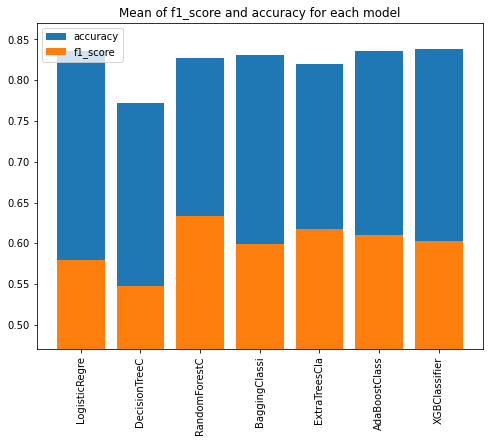

In [250]:
f = np.array([])
ac = np.array([])
nam = np.array([])
for i in all_scores.model.unique():
    f = np.append(f, (all_scores.f1_score[all_scores.model == i].mean()))
    ac = np.append(ac, (all_scores.accuracy[all_scores.model == i].mean()))
    nam = np.append(nam, ((f'{i}')[:13]))
plt.figure(figsize=(8,6))
plt.bar(nam, ac, label = 'accuracy')
plt.bar(nam, f, label = 'f1_score')
plt.ylim(0.47,0.87)
plt.xticks(rotation = 90)
plt.legend()
plt.title('Mean of f1_score and accuracy for each model')
plt.show()

Sorted models by f1_score mean from different datasets

In [251]:
all_scores.model.unique()[f.argsort()[::-1]]

array([RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                              random_state=42)                                    ,
       ExtraTreesClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                            random_state=42)                                    ,
       AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20,
                                                                max_features='auto',
                                                                min_samples_leaf=2,
                                                                random_state=42),
                          learning_rate=1, n_estimators=200, random_state=42)       ,
       XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                     colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
                     importance_type='gain', interaction_constraints='',
                     le

Sorted models by accuracy mean from different datasets

In [252]:
all_scores.model.unique()[ac.argsort()[::-1]]

array([XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                     colsample_bynode=1, colsample_bytree=1, gamma=0.3, gpu_id=-1,
                     importance_type='gain', interaction_constraints='',
                     learning_rate=0.300000012, max_delta_step=0, max_depth=20,
                     min_child_weight=1, missing=nan, monotone_constraints='()',
                     n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=42,
                     reg_alpha=0, reg_lambda=0.2, scale_pos_weight=1, subsample=1,
                     tree_method='exact', validate_parameters=1, verbosity=None)      ,
       LogisticRegression(C=0.1, penalty='l1', random_state=42, solver='saga'),
       AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20,
                                                                max_features='auto',
                                                                min_samples_leaf=2,
                      

The bests models for f1_score are made by RandomForestClassifier and ExtraTreesClassifier algorithms 

The bests models for accuracy are made by XGBClassifier and LogisticRegression algorithms 

#### What data preparation was the best?

In [322]:
all_scores.model.unique()[1]

DecisionTreeClassifier(max_depth=20, max_features='auto', min_samples_leaf=20,
                       random_state=42)

In [324]:
all_scores[~(all_scores.model == all_scores.model.unique()[1])]

,set,size_train,size_test,model,accuracy,f1_score
0,_full,"(50156, 92)","(6264, 92)","LogisticRegression(C=0.1, penalty='l1', random...",0.8370,0.5868
2,_full,"(50156, 92)","(6264, 92)","(DecisionTreeClassifier(max_depth=20, max_feat...",0.8276,0.6386
3,_full,"(50156, 92)","(6264, 92)",(DecisionTreeClassifier(random_state=195292617...,0.8370,0.6214
4,_full,"(50156, 92)","(6264, 92)","(ExtraTreeClassifier(max_depth=20, min_samples...",0.8202,0.6296
5,_full,"(50156, 92)","(6264, 92)","(DecisionTreeClassifier(max_depth=20, max_feat...",0.8424,0.6329
...,...,...,...,...,...,...
79,_M_l,"(115122, 66)","(6264, 66)","(DecisionTreeClassifier(max_depth=20, max_feat...",0.8265,0.6266
80,_M_l,"(115122, 66)","(6264, 66)",(DecisionTreeClassifier(random_state=195292617...,0.8268,0.5841
81,_M_l,"(115122, 66)","(6264, 66)","(ExtraTreeClassifier(max_depth=20, min_samples...",0.8186,0.6185
82,_M_l,"(115122, 66)","(6264, 66)","(DecisionTreeClassifier(max_depth=20, max_feat...",0.8349,0.6059


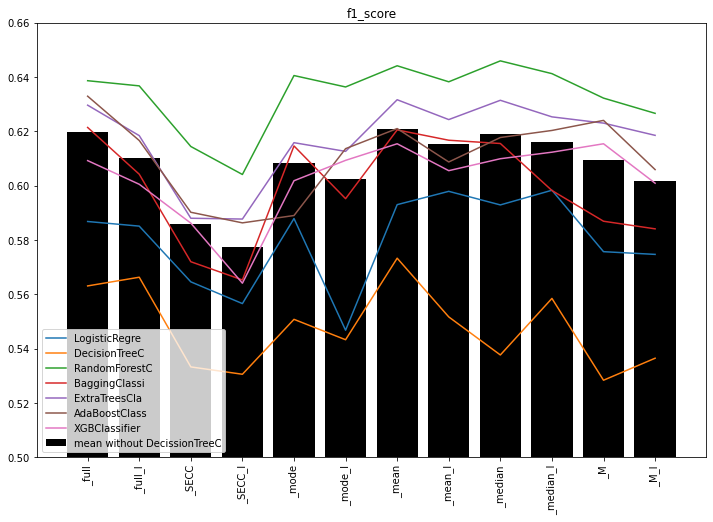

In [334]:
mf = np.array([])
mac = np.array([])
x = all_scores.set.unique()
all_sc = all_scores[~(all_scores.model == all_scores.model.unique()[1])]
for i in all_sc.set.unique():
    mf = np.append(mf, all_sc.f1_score[all_sc.set == i].mean())
    mac = np.append(mac, all_sc.accuracy[all_sc.set == i].mean())
plt.figure(figsize=(12,8))
plt.bar(x, mf, color = 'k',label='mean without DecissionTreeC')    
for j in all_scores.model.unique():
    plt.plot(x,(all_scores.f1_score[all_scores.model == j]), label = f'{j}'[:13])
plt.ylim(0.5,0.66)
plt.xticks(rotation = 90)
plt.title('f1_score')
plt.legend()
plt.show()


Sorted datasets by f1_score mean from models

In [256]:
all_scores.set.unique()[mf.argsort()[::-1]]

array(['_mean', '_full', '_median_l', '_median', '_mean_l', '_full_l',
       '_mode', '_M', '_mode_l', '_M_l', '_SECC', '_SECC_l'], dtype=object)

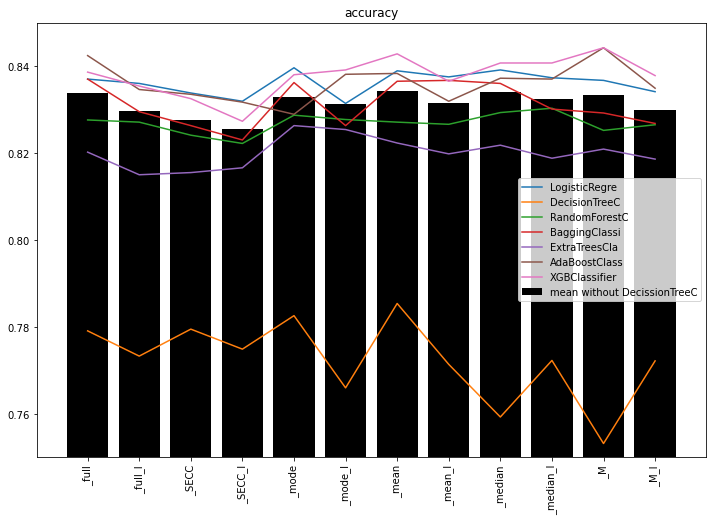

In [333]:
plt.figure(figsize=(12,8))
plt.bar(x, mac, color = 'k', label='mean without DecissionTreeC')    
for k in all_scores.model.unique():
    plt.plot(x,(all_scores.accuracy[all_scores.model == k]), label = f'{k}'[:13])
plt.ylim(0.75,0.85)
plt.xticks(rotation = 90)
plt.title('accuracy')
plt.legend()
plt.show()

Sorted datasets by accuracy mean from models

In [259]:
all_scores.set.unique()[mac.argsort()[::-1]]

array(['_mean', '_full', '_mode', '_median_l', '_median', '_mean_l',
       '_mode_l', '_M', '_M_l', '_full_l', '_SECC', '_SECC_l'],
      dtype=object)

The best f1_score

In [260]:
all_scores.loc[all_scores.f1_score.argmax()]

set                                                     _median
size_train                                        (115122, 115)
size_test                                           (6264, 115)
model         (DecisionTreeClassifier(max_depth=20, max_feat...
accuracy                                                 0.8293
f1_score                                                 0.6459
Name: 58, dtype: object

In [320]:
all_scores.loc[all_scores.f1_score.argmax()].model

RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300,
                       random_state=42)

The best accuracy

In [261]:
all_scores.loc[all_scores.accuracy.argmax()]

set                                                          _M
size_train                                        (115122, 115)
size_test                                           (6264, 115)
model         (DecisionTreeClassifier(max_depth=20, max_feat...
accuracy                                                 0.8442
f1_score                                                  0.624
Name: 75, dtype: object

In [275]:
all_scores.loc[all_scores.accuracy.argmax()].model

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=20,
                                                         max_features='auto',
                                                         min_samples_leaf=2,
                                                         random_state=42),
                   learning_rate=1, n_estimators=200, random_state=42)

Scores for model with the best f1_score - RandomForestClassifier sorted by f1_score

In [296]:
all_scores[all_scores.model == all_scores.model.loc[2]].sort_values('f1_score',ascending=False)

,set,size_train,size_test,model,accuracy,f1_score
58,_median,"(115122, 115)","(6264, 115)","(DecisionTreeClassifier(max_depth=20, max_feat...",0.8293,0.6459
44,_mean,"(115122, 115)","(6264, 115)","(DecisionTreeClassifier(max_depth=20, max_feat...",0.8271,0.6441
65,_median_l,"(115122, 66)","(6264, 66)","(DecisionTreeClassifier(max_depth=20, max_feat...",0.8303,0.6412
30,_mode,"(115122, 115)","(6264, 115)","(DecisionTreeClassifier(max_depth=20, max_feat...",0.8287,0.6405
2,_full,"(50156, 92)","(6264, 92)","(DecisionTreeClassifier(max_depth=20, max_feat...",0.8276,0.6386
51,_mean_l,"(115122, 66)","(6264, 66)","(DecisionTreeClassifier(max_depth=20, max_feat...",0.8266,0.6382
9,_full_l,"(50156, 66)","(6264, 66)","(DecisionTreeClassifier(max_depth=20, max_feat...",0.8271,0.6367
37,_mode_l,"(115122, 66)","(6264, 66)","(DecisionTreeClassifier(max_depth=20, max_feat...",0.8277,0.6363
72,_M,"(115122, 115)","(6264, 115)","(DecisionTreeClassifier(max_depth=20, max_feat...",0.8252,0.6322
79,_M_l,"(115122, 66)","(6264, 66)","(DecisionTreeClassifier(max_depth=20, max_feat...",0.8265,0.6266


In [279]:
d = (all_scores[all_scores.model == all_scores.model.loc[2]].sort_values("f1_score",ascending=False).iloc[0,5] - \
     all_scores[all_scores.model == all_scores.model.loc[2]].sort_values("f1_score",ascending=False).iloc[-1,5])*100
print(f'{round(d,2)}% difference in f1_score compared to the best model for df_median and the worst model for df_SECC_l')

4.18% difference in f1_score compared to the best model for df_median and the worst model for df_SECC_l


Scores for model with the best accuracy  - XGBClassifier sorted by accuracy

In [267]:
all_scores[all_scores.model == all_scores.model.loc[6]].sort_values('accuracy',ascending=False)

,set,size_train,size_test,model,accuracy,f1_score
76,_M,"(115122, 115)","(6264, 115)","XGBClassifier(base_score=0.5, booster='gbtree'...",0.8442,0.6154
48,_mean,"(115122, 115)","(6264, 115)","XGBClassifier(base_score=0.5, booster='gbtree'...",0.8428,0.6154
62,_median,"(115122, 115)","(6264, 115)","XGBClassifier(base_score=0.5, booster='gbtree'...",0.8407,0.6099
69,_median_l,"(115122, 66)","(6264, 66)","XGBClassifier(base_score=0.5, booster='gbtree'...",0.8407,0.6123
41,_mode_l,"(115122, 66)","(6264, 66)","XGBClassifier(base_score=0.5, booster='gbtree'...",0.8391,0.6093
6,_full,"(50156, 92)","(6264, 92)","XGBClassifier(base_score=0.5, booster='gbtree'...",0.8386,0.6092
34,_mode,"(115122, 115)","(6264, 115)","XGBClassifier(base_score=0.5, booster='gbtree'...",0.8380,0.6018
83,_M_l,"(115122, 66)","(6264, 66)","XGBClassifier(base_score=0.5, booster='gbtree'...",0.8378,0.6009
55,_mean_l,"(115122, 66)","(6264, 66)","XGBClassifier(base_score=0.5, booster='gbtree'...",0.8365,0.6055
13,_full_l,"(50156, 66)","(6264, 66)","XGBClassifier(base_score=0.5, booster='gbtree'...",0.8354,0.6005


In [280]:
d = (all_scores[all_scores.model == all_scores.model.loc[6]].sort_values("accuracy",ascending=False).iloc[0,5] - \
     all_scores[all_scores.model == all_scores.model.loc[6]].sort_values("accuracy",ascending=False).iloc[-1,5])*100
print(f'{round(d,2)}% difference in accuracy compared to the best model for df_M and the worst model for df_SECC_l')

5.13% difference in accuracy compared to the best model for df_M and the worst model for df_SECC_l


In [270]:
print(f'{round((1-(23/49))*100)}% of not missing location in df_full')

53% of not missing location in df_full


In [245]:
scores_replaced = pd.concat([scores_mode2, scores_mode_l2, scores_mean2, scores_mean_l2, scores_median2,  scores_median_l2, scores_M2, scores_M_l2], ignore_index=True)

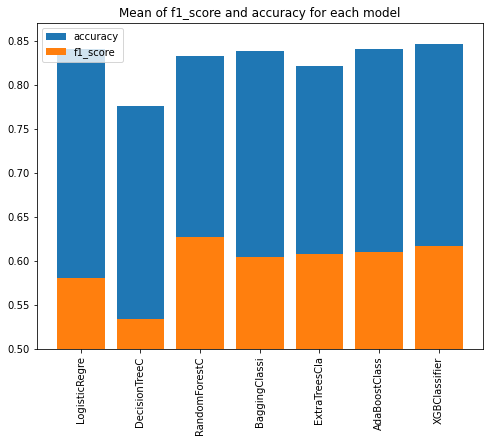

In [283]:
f2 = np.array([])
ac2 = np.array([])
nam2 = np.array([])
for i in scores_replaced.model.unique():
    f2 = np.append(f2, (scores_replaced.f1_score[scores_replaced.model == i].mean()))
    ac2 = np.append(ac2, (scores_replaced.accuracy[scores_replaced.model == i].mean()))
    nam2 = np.append(nam2, ((f'{i}')[:13]))
plt.figure(figsize=(8,6))
plt.bar(nam2, ac2, label = 'accuracy')
plt.bar(nam2, f2, label = 'f1_score')
plt.ylim(0.5,0.87)
plt.xticks(rotation = 90)
plt.legend()
plt.title('Mean of f1_score and accuracy for each model')
plt.show()

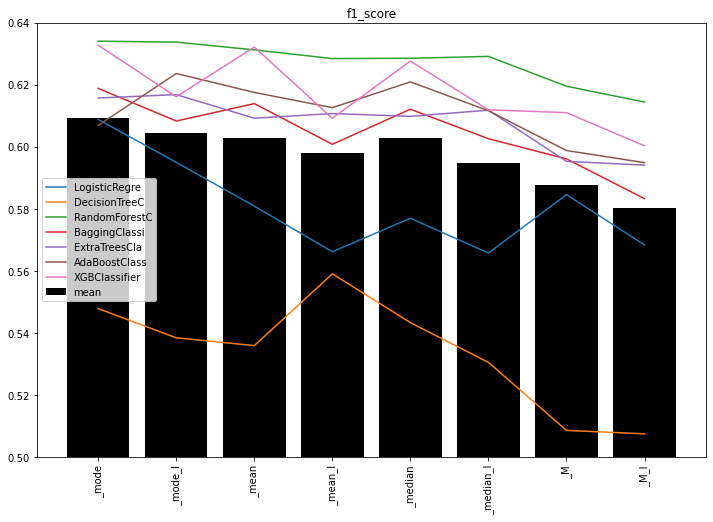

In [285]:
mf2 = np.array([])
mac2 = np.array([])
x2 = scores_replaced.set.unique()

for i in scores_replaced.set.unique():
    mf2 = np.append(mf2, scores_replaced.f1_score[scores_replaced.set == i].mean())
    mac2 = np.append(mac2, scores_replaced.accuracy[scores_replaced.set == i].mean())
plt.figure(figsize=(12,8))
plt.bar(x2, mf2, color = 'k',label='mean')    
for j in scores_replaced.model.unique():
    plt.plot(x2,(scores_replaced.f1_score[scores_replaced.model == j]), label = f'{j}'[:13])
plt.ylim(0.5,0.64)
plt.xticks(rotation = 90)
plt.title('f1_score')
plt.legend()
plt.show()


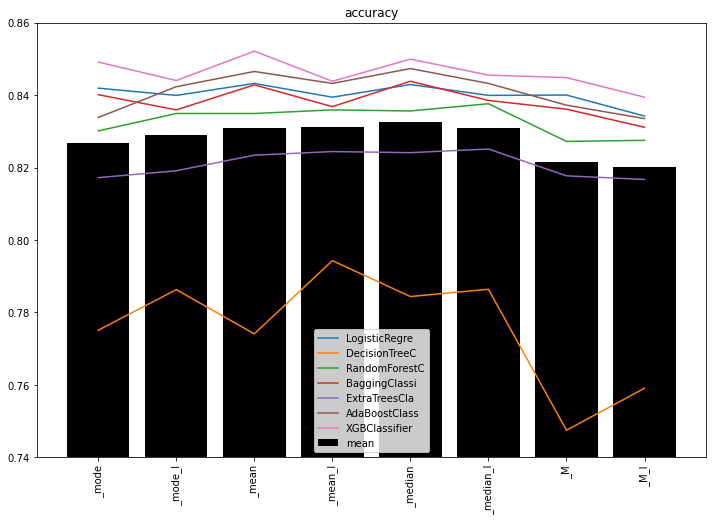

In [289]:
plt.figure(figsize=(12,8))
plt.bar(x2, mac2, color = 'k', label='mean')    
for k in scores_replaced.model.unique():
    plt.plot(x2,(scores_replaced.accuracy[scores_replaced.model == k]), label = f'{k}'[:13])
plt.ylim(0.74,0.86)
plt.xticks(rotation = 90)
plt.title('accuracy')
plt.legend()
plt.show()

## 9. Summary

Becouse data is imbalanced the better metric is f1_score.

The best f1_score (64.59%) is forRandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=300, random_state=42) - for data with filled data  (df_full).



But drop all missing data caused eliminate 38.79% of data including 23 locations from 49. The model is usefull only for 53% of locations. 

Replacement the missing data resulted a decrease of the f1_score <3.44% - 5.22%> for the estimator with the best mean f1_score - RandomForestClassifier and an increase utility to 100%. 

The best replacement for missing data is replace numeric variables by mean and object variables by random sample of from not missing items (df_mean).  f1_score ↓ by 3.44%

The worst replacment for missing data is replace all variables by random sample of from not missing items for every month (df_M). f1_score ↓ by 5.22%

Models which included locations have better f1_score, but dropping locations will decrease f1_score by less than 1% and increase utility of models for new locations.